In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # #                                         # # # # # # #
# # # # # # #             Dimple Surface              # # # # # # # 
# # # # # # #                                         # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

In [ ]:
from veech import *

In [ ]:
def define_dimple(x,y):

    def rectangle(a,b):
        return polygons(vertices = [(0,0),(a,0),(a,b),(0,b)])

    P1 = rectangle(x,y)
    Q1 = rectangle(1,y)
    R1 = rectangle(1,1)
    S1 = rectangle(y,1)
    
    s = Surface_list(QQ)

    s.add_polygon(P1)
    s.add_polygon(Q1)
    s.add_polygon(R1)
    s.add_polygon(S1)

    S = SimilaritySurface(s)

    s.set_edge_pairing(0,0,3,2)
    s.set_edge_pairing(0,1,1,3)
    s.set_edge_pairing(0,2,3,0)
    s.set_edge_pairing(0,3,1,1)
    s.set_edge_pairing(1,0,2,2)
    s.set_edge_pairing(1,2,2,0)
    s.set_edge_pairing(2,1,3,3)
    s.set_edge_pairing(2,3,3,1)

    gs = S.graphical_surface()

    gs.make_adjacent(1,2)
    gs.make_adjacent(2,1)    
    
    DS = S.minimal_cover(cover_type='dilation').copy(relabel=True)
    
    return DS, S, gs, s

DS, S, gs, s = define_dimple(1/2,2)
gs.plot()


# We first imagined the Dimple surface as a (1 by 1) square torus surface
# with an (x by x) square cut out, and replaced by a (1 by y) rectangle.
# 
# Then, we chose a presentation with the cut-out in the lower-left corner.
# 
# The simplest presentation might be the following reparameterization:
# Normalize Box 2 to be a unit square, and let x and y vary as the height and width of Box 0, respecetively.

In [ ]:
def search_dimple(x,y,iters=100):
    DS, S, gs, s = define_dimple(x,y)
    print('x,y = ' + str(x) + ', ' + str(y))
    IDC1 = IDC(DS, iters, veech = 1, show_current_sym = 0) # Change 1 to > 100
    show(IDC1.plot(model = 'UHP', figsize = 5)) #UHP or KM
    gs.plot()
    show(list(IDC1.generators(normalize_det=1)))
    
# Using FlatSurf, we are searching for Veech elements under certain simple parameters.
# Under the number of iterations we've tried, Flatsurf doesn't terminate for any of the following,
# it just keeps finding more and more veech elements.

In [ ]:
# search_dimple(1,1) This is the square torus.
search_dimple(2,1)
search_dimple(3,1)
search_dimple(4,1)

In [ ]:
# The horizontal left-right sheers are generated by    [[1,z],    where  z = lcm( (x + 1)/y, y + 1).
#                                                       [0,1]]
#                                                               
# 
# The vertical up-down sheers are generated by         [[1, 0],   where z' = lcm(1/(y+1), xy/(y^2 + x)).
#                                                       [z',1]]
#                                                               
# 
# This is because the surface decomposes into horizontal cylinders of moduli (x + 1)/y and y + 1,
# and it decomposes into vertical cylinders of moduli 1/(y+1) and xy/(y^2 + x).
# 
# These formulas match the results produced above,
# namely, the entries 6, 4, and 10 in the first matrices of the above three groups.

In [294]:
DS, S, gs, s = define_dimple(2,1)
IDC1 = IDC(DS, 40, veech = 1, show_current_sym = 0) # Change 1 to > 100
# show(IDC1.plot(model = 'UHP', figsize = 5)) #UHP or KM
# gs.plot()
veech_matrices = list(IDC1.generators(normalize_det=1))
show(veech_matrices)

# Using FlatSurf, we are searching for Veech elements under certain simple parameters.
# Under the number of iterations we've tried, Flatsurf doesn't terminate for any of the following,
# it just keeps finding more and more veech elements.


IDR 40/40 --> 3.55 seconds


[
[1 6]  [-1  0]
[0 1], [ 0 -1]
]

In [296]:
DS, S, gs, s = define_dimple(2,1)

In [295]:
A = matrix([[1, 6],
            [0, 1]])

In [ ]:
show(DS.plot())
show((A*DS).plot())

In [ ]:
show((DS).delaunay_triangulation().plot())
show((A*DS).delaunay_triangulation().plot())

In [ ]:
show(DS.delaunay_decomposition().plot())
show((A*DS).delaunay_decomposition().plot())

In [ ]:
show(DS.canonicalize().plot())
show((A*DS).canonicalize().plot())

In [ ]:
print((A*DS).delaunay_triangulation() == DS.delaunay_triangulation())
print((A*DS).delaunay_decomposition() == DS.delaunay_decomposition())
print(DS.canonicalize() == (A*DS).canonicalize())

In [ ]:
all_veech_matrices = {}

In [ ]:
def display_info(parameters, i = 0):
    print('parameters = ' + parameters)

    print('\nveech_matrices:')
    show(all_veech_matrices[parameters][0])

    print('\neigenvectors:')
    count = 0
    for m in all_veech_matrices[parameters][0]:
        print(str(count) + ' '*(count<10) + ' : ' + str(m.eigenvectors_right()[0][1][0]))
        count += 1

    print('\nchoose: veech matrix:')
    print(all_veech_matrices[parameters][0][i])

    print('\nchoose: eigenvector:')
    eigen = list(all_veech_matrices[parameters][0][i].eigenvectors_right()[0][1][0])
    print(eigen)

    v = all_veech_matrices[parameters][1].tangent_vector(0, (1/51,1/51), eigen)
    traj = v.straight_line_trajectory()
    traj.flow(1000)
    print('\nclosed: ' + str(traj.is_closed()))
    print('saddle: ' + str(traj.is_saddle_connection()))
    show(all_veech_matrices[parameters][1].plot() + traj.cylinder().plot(alpha=.4, color = 'red') + traj.plot(color='red', thickness = 2))
    

In [ ]:
DS, S, gs, s = define_dimple(1,1)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['1,1'] = [list(IDC1.generators(normalize_det=1)),S]

parameters = 1,1

veech_matrices:


[
[ 0 -1]  [ 0  1]  [-1  0]  [-1  0]
[ 1  2], [-1  0], [ 0 -1], [-1 -1]
]


eigenvectors:
0  : (1, -1)
1  : (1, -1*I)
2  : (1, 0)
3  : (0, 1)

choose: veech matrix:
[-1  0]
[ 0 -1]

choose: eigenvector:
[1, 0]

closed: True
saddle: False


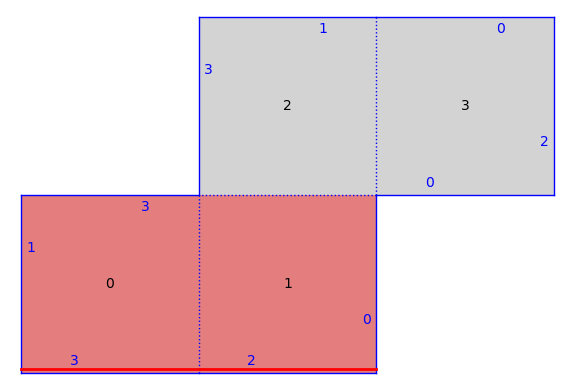

In [283]:
display_info('1,1',2)

In [ ]:
DS, S, gs, s = define_dimple(2,1)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['2,1'] = [list(IDC1.generators(normalize_det=1)),S]

parameters = 2,1

veech_matrices:


[
[161 144]  [ 29 -20]  [ 119  180]  [ 31 -20]  [ 121  180]  [ 121 -180]
[180 161], [ 45 -31], [ -80 -121], [ 45 -29], [ -80 -119], [  80 -119],

[    47    -77]  [ 473/2   -107]  [-15  32]  [ 21  11]  [-15 -32]
[-119/2  195/2], [-305/2     69], [ -8  17], [-44 -23], [  8  17],

[ 23  11]  [ 29  20]  [1205/4 -373/2]  [ 23 -11]  [-479/2 -689/2]
[-44 -21], [-45 -31], [-869/4  269/2], [ 44 -21], [-333/2 -479/2],

[-14  -5]  [-203 -153]  [   -295     128]  [-161  144]  [65 53]
[-39 -14], [ 272  205], [-1369/2     297], [ 180 -161], [38 31],

[19/2 51/2]  [-479/2  689/2]  [ 205 -153]  [31 53]  [473/2   107]
[ 7/2 19/2], [ 333/2 -479/2], [ 272 -203], [38 65], [305/2    69],

[-31 -20]  [ -269/2   373/2]  [1 6]  [1 0]  [   69   107]  [-23 -11]
[ 45  29], [  869/4 -1205/4], [0 1], [6 1], [305/2 473/2], [ 44  21],

[   -47     77]  [  -295   -128]  [-119  180]  [ 797/4 1157/4]
[ 119/2 -195/2], [1369/2    297], [ -80  121], [ 549/4  797/4],

[ 195/2    -77]  [-1  0]
[-119/2     47], [ 0 -1]
]


eigenvectors:
0  : (1, -1.118033988749895?)
1  : (1, 3/2)
2  : (1, -2/3)
3  : (1, 3/2)
4  : (1, -2/3)
5  : (1, 2/3)
6  : (1, 0.6102997305624648?)
7  : (1, 2.210249781705650?)
8  : (1, 1/2)
9  : (1, -2)
10 : (1, -1/2)
11 : (1, -2)
12 : (1, -3/2)
13 : (1, 1.615269196214759?)
14 : (1, 2)
15 : (1, 0.6952043898642342?)
16 : (1, 2.792848008753789?)
17 : (1, -4/3)
18 : (1, 37/16)
19 : (1, -1.118033988749895?)
20 : (1, -1.226218532128440?)
21 : (1, -0.3704792868174742?)
22 : (1, -0.6952043898642342?)
23 : (1, 4/3)
24 : (1, -0.5847090981661756?)
25 : (1, -2.210249781705650?)
26 : (1, -3/2)
27 : (1, -1.615269196214759?)
28 : (1, 0)
29 : (0, 1)
30 : (1, -0.6448292209579862?)
31 : (1, -2)
32 : (1, -1.266143886406621?)
33 : (1, -37/16)
34 : (1, 2/3)
35 : (1, -0.6888417997369373?)
36 : (1, 1.266143886406621?)
37 : (1, 0)

choose: veech matrix:
[ 29 -20]
[ 45 -31]

choose: eigenvector:
[1, 3/2]

closed: True
saddle: False


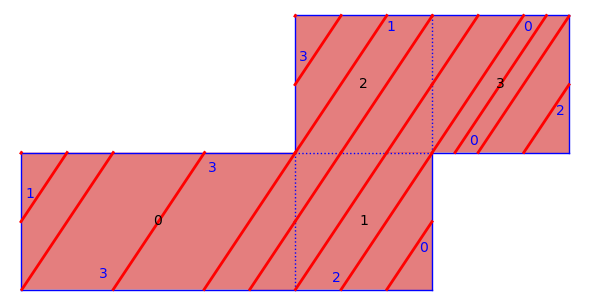

In [284]:
display_info('2,1',1)

In [ ]:
DS, S, gs, s = define_dimple(3,1)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['3,1'] = [list(IDC1.generators(normalize_det=1)),S]

parameters = 3,1

veech_matrices:


[
[47 92]  [ 929/3    238]  [   111    -84]  [   145   -238]  [139 118]
[24 47], [-566/3   -145], [-440/3    111], [ 566/3 -929/3], [-86 -73],

[-1 -4]  [-1373/3 -2192/3]  [  73 -118]  [1 0]  [ -73 -118]
[ 0 -1], [ -860/3 -1373/3], [  86 -139], [4 1], [  86  139],

[ 557  284]  [-155 -284]  [   -49    -36]  [-1  0]  [-929/3    238]
[-304 -155], [ 304  557], [-200/3    -49], [ 0 -1], [-566/3    145]
]


eigenvectors:
0  : (1, -0.510753918455250?)
1  : (1, -1.301094930958781?)
2  : (1, 1.321374945286820?)
3  : (1, 1.301094930958781?)
4  : (1, -1.177837669533401?)
5  : (1, 0)
6  : (1, 0.6263671179295395?)
7  : (1, 1.177837669533401?)
8  : (0, 1)
9  : (1, -0.6187724999581247?)
10 : (1, -1.961258846557810?)
11 : (1, -0.5457834069633176?)
12 : (1, 1.360827634879544?)
13 : (1, 0)
14 : (1, 0.6092692146994826?)

choose: veech matrix:
[-1 -4]
[ 0 -1]

choose: eigenvector:
[1, 0]

closed: True
saddle: False


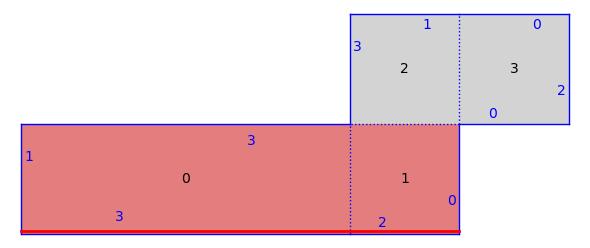

In [285]:
display_info('3,1',5)

In [ ]:
DS, S, gs, s = define_dimple(4,1)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['4,1'] = [list(IDC1.generators(normalize_det=1)),S]

parameters = 4,1

veech_matrices:


[
[ 61/4 285/4]  [-45 -88]  [ -1 -10]  [ 43 -88]  [ 1  0]  [-1  0]
[ 13/4  61/4], [ 22  43], [  0  -1], [ 22 -45], [10  1], [ 0 -1]
]


eigenvectors:
0  : (1, -0.2135744251723959?)
1  : (1, -1/2)
2  : (1, 0)
3  : (1, 1/2)
4  : (0, 1)
5  : (1, 0)

choose: veech matrix:
[-45 -88]
[ 22  43]

choose: eigenvector:
[1, -1/2]

closed: True
saddle: False


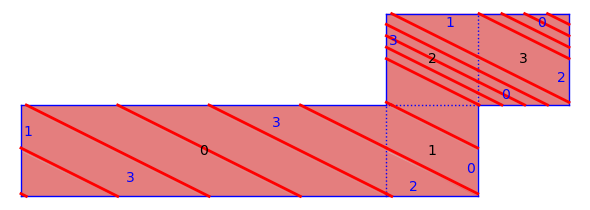

In [286]:
display_info('4,1',1)

In [ ]:
DS, S, gs, s = define_dimple(2,2)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['2,2'] = [list(IDC1.generators(normalize_det=1)),S]

parameters = 2,2

veech_matrices:


[
[ 4  3]  [-3 -1]  [ 0  1]  [-1  0]
[-3 -2], [ 1  0], [-1  0], [ 0 -1]
]


eigenvectors:
0  : (1, -1)
1  : (1, -0.3819660112501051?)
2  : (1, -1*I)
3  : (1, 0)

choose: veech matrix:
[ 4  3]
[-3 -2]

choose: eigenvector:
[1, -1]

closed: True
saddle: False


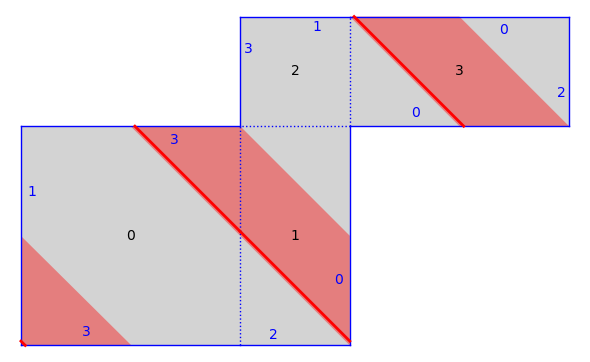

In [291]:
display_info('2,2',0)

In [297]:
DS, S, gs, s = define_dimple(3,2)
IDC1 = IDC(DS, 2000, veech = 1, show_current_sym = 0)
all_veech_matrices['3,2'] = [list(IDC1.generators(normalize_det=1)),S]


IDR 2000/2000 --> 401.94 seconds


parameters = 3,2

veech_matrices:


[
[-43/3 -92/3]  [-43/3  92/3]  [1 6]  [-49/3 -92/3]  [-1  0]
[ 23/3  49/3], [-23/3  49/3], [0 1], [ 23/3  43/3], [ 0 -1],

[ 43/3 -92/3]
[ 23/3 -49/3]
]


eigenvectors:
0  : (1, -1/2)
1  : (1, 1/2)
2  : (1, 0)
3  : (1, -1/2)
4  : (1, 0)
5  : (1, 1/2)

choose: veech matrix:
[-43/3 -92/3]
[ 23/3  49/3]

choose: eigenvector:
[1, -1/2]

closed: True
saddle: False


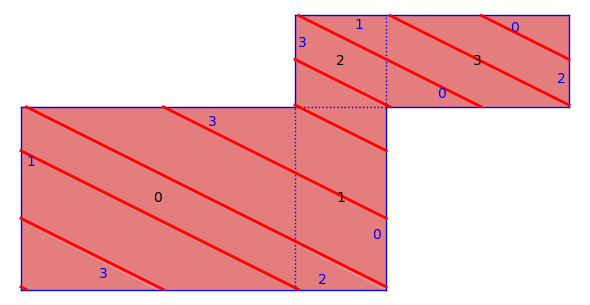

In [310]:
display_info('3,2',0)

In [299]:
DS, S, gs, s = define_dimple(4,2)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['4,2'] = [list(IDC1.generators(normalize_det=1)),S]

/private/var/tmp/sage-9.6-current/local/var/lib/sage/venv-python3.10.3/lib/python3.10/site-packages/ipykernel/iostream.py:214: RuntimeWarning: cypari2 leaked 381800 bytes on the PARI stack
  self._event_pipe.send(b'')


IDR 3000/3000 --> 674.05 seconds


parameters = 4,2

veech_matrices:


[
[ -65 -121]  [ 67 121]  [ 141  490]  [  34 -175]  [-58 171]  [ 14 -13]
[  36   67], [-36 -65], [ -40 -139], [   7  -36], [-19  56], [ 13 -12],

[ -1 -15]  [ 69 175]  [  56 -171]  [-14 -13]  [1 0]  [ -36 -175]
[  0  -1], [-28 -71], [  19  -58], [ 13  12], [3 1], [   7   34],

[  65 -121]  [-36 175]  [-69 175]  [ -56 -171]  [-1  0]
[  36  -67], [ -7  34], [-28  71], [  19   58], [ 0 -1]
]


eigenvectors:
0  : (1, -6/11)
1  : (1, -6/11)
2  : (1, -2/7)
3  : (1, 1/5)
4  : (1, 1/3)
5  : (1, 1)
6  : (1, 0)
7  : (1, -2/5)
8  : (1, 1/3)
9  : (1, -1)
10 : (0, 1)
11 : (1, -1/5)
12 : (1, 6/11)
13 : (1, 1/5)
14 : (1, 2/5)
15 : (1, -1/3)
16 : (1, 0)

choose: veech matrix:
[ -65 -121]
[  36   67]

choose: eigenvector:
[1, -6/11]

closed: True
saddle: False


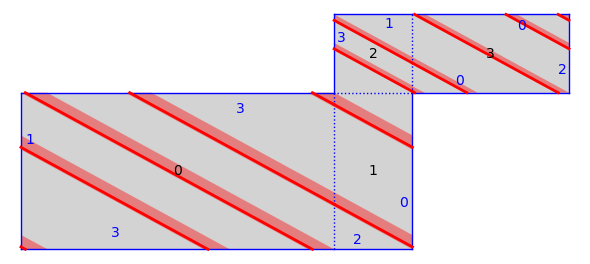

In [309]:
display_info('4,2',0)

In [302]:
DS, S, gs, s = define_dimple(5,2)
IDC1 = IDC(DS, 2000, veech = 1, show_current_sym = 0)
all_veech_matrices['5,2'] = [list(IDC1.generators(normalize_det=1)),S]


IDR 2000/2000 --> 369.11 seconds


parameters = 5,2

veech_matrices:


[
[1 3]  [-1  0]  [   134     75]  [-1  0]
[0 1], [-9 -1], [1197/5    134], [ 0 -1]
]


eigenvectors:
0  : (1, 0)
1  : (0, 1)
2  : (1, -1.786616914730184?)
3  : (1, 0)

choose: veech matrix:
[1 3]
[0 1]

choose: eigenvector:
[1, 0]

closed: True
saddle: False


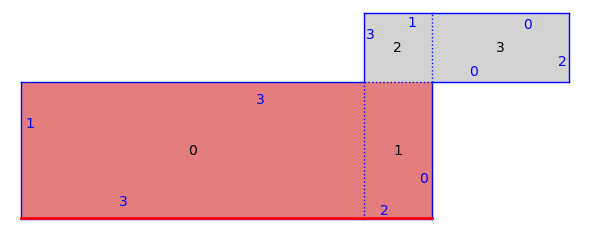

In [308]:
display_info('5,2',0)

In [303]:
DS, S, gs, s = define_dimple(1,3)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['1,3'] = [list(IDC1.generators(normalize_det=1)),S]


IDR 3000/3000 --> 752.89 seconds


parameters = 1,3

veech_matrices:


[
[  129   120]  [   -79    -72]  [-89  36]  [-1  4]  [ -89  -36]
[416/3   129], [-260/3    -79], [220 -89], [ 0 -1], [-220  -89],

[    47    -36]  [ -1   0]  [ 1  0]  [-1 -4]  [   47    36]
[-184/3     47], [-20  -1], [20  1], [ 0 -1], [184/3    47],

[   -49    -36]  [-1  0]
[-200/3    -49], [ 0 -1]
]


eigenvectors:
0  : (1, -1.074967699773140?)
1  : (1, 1.097134314340639?)
2  : (1, -2.472066162365221?)
3  : (1, 0)
4  : (1, 2.472066162365221?)
5  : (1, 1.305260013830082?)
6  : (0, 1)
7  : (0, 1)
8  : (1, 0)
9  : (1, -1.305260013830082?)
10 : (1, 1.360827634879544?)
11 : (1, 0)

choose: veech matrix:
[ 1  0]
[20  1]

choose: eigenvector:
[0, 1]

closed: True
saddle: False


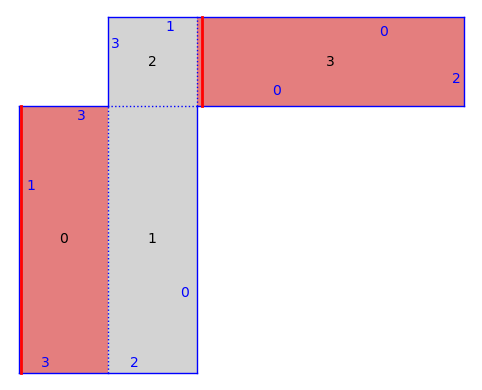

In [307]:
display_info('1,3',7)

In [304]:
DS, S, gs, s = define_dimple(2,3)
IDC1 = IDC(DS, 3000, veech = 1, show_current_sym = 0)
all_veech_matrices['2,3'] = [list(IDC1.generators(normalize_det=1)),S]


IDR 3000/3000 --> 797.55 seconds


parameters = 2,3

veech_matrices:


[
[-39/2 -41/2]  [-1  4]  [ 43/2  41/2]  [ 1 -4]  [-1  0]  [ 39/2 -41/2]
[ 41/2  43/2], [ 0 -1], [-41/2 -39/2], [ 0  1], [ 0 -1], [ 41/2 -43/2]
]


eigenvectors:
0  : (1, -1)
1  : (1, 0)
2  : (1, -1)
3  : (1, 0)
4  : (1, 0)
5  : (1, 1)

choose: veech matrix:
[-39/2 -41/2]
[ 41/2  43/2]

choose: eigenvector:
[1, -1]

closed: True
saddle: False


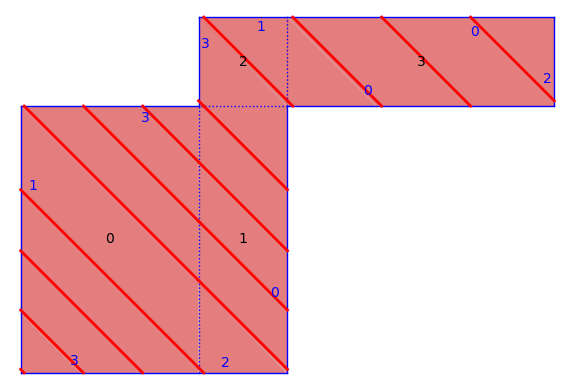

In [305]:
display_info('2,3',0)

In [ ]:
# sage: cyl.holonomy()
# (3*a + 4, 2*a + 3)
# sage: cyl.edges()
# (2, 3, 3, 2, 4)
# cyl.polygons()
# b = cyl.boundary()